In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fix import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()
from utils.load_data import load_telecom_data, load_multi_telecom_data
from utils.manipulate_data import df2cell_time_array, df2timeindex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from tqdm import tqdm
from sklearn.preprocessing import MaxAbsScaler

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# data = load_telecom_data('../data/sms-call-internet-mi/sms-call-internet-mi-2013-11-01.csv')

paths = ['/home/zzw/dataset/TeleMilan/sms-call-internet-mi/sms-call-internet-mi-2013-11-0{i}.csv'.format(i=i) for i in range(1, 5)]
data = load_multi_telecom_data(paths)

loading data from file: /home/zzw/dataset/TeleMilan/sms-call-internet-mi/sms-call-internet-mi-2013-11-01.csv
loading data from file: /home/zzw/dataset/TeleMilan/sms-call-internet-mi/sms-call-internet-mi-2013-11-02.csv
loading data from file: /home/zzw/dataset/TeleMilan/sms-call-internet-mi/sms-call-internet-mi-2013-11-03.csv
loading data from file: /home/zzw/dataset/TeleMilan/sms-call-internet-mi/sms-call-internet-mi-2013-11-04.csv
loaded 5759907 rows


In [ ]:
data.head()

,cellid,time,smsin,smsout,callin,callout,internet
0,1,2013-11-01 00:00:00,0.223227,0.156787,0.160938,0.052275,11.028366
1,1,2013-11-01 00:10:00,0.415040,0.119926,0.188777,0.160938,11.127101
2,1,2013-11-01 00:20:00,0.384079,0.170952,0.134176,0.054601,10.892771
3,1,2013-11-01 00:30:00,0.707572,0.220815,0.027300,0.053438,8.622425
4,1,2013-11-01 00:40:00,0.270679,0.192891,0.053438,0.080738,8.009927


In [ ]:
data.describe().applymap(lambda x: f"{x:0.3f}")

,cellid,smsin,smsout,callin,callout,internet
count,1439982.000,1439982.000,1439982.000,1439982.000,1439982.000,1439982.000
mean,5000.481,3.199,1.960,1.821,2.220,57.278
std,2886.762,6.678,4.274,3.838,4.562,94.694
min,1.000,0.000,0.000,0.000,0.000,0.000
25%,2500.000,0.261,0.169,0.089,0.128,10.704
50%,5000.000,1.036,0.627,0.509,0.647,26.965
75%,7500.000,3.367,1.973,1.880,2.302,62.643
max,10000.000,463.282,295.726,215.219,197.897,5063.972


In [ ]:
# Count number of zeros in all columns of Dataframe
for column_name in data.columns:
    column = data[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

Count of zeros in column  cellid  is :  0
Count of zeros in column  time  is :  0
Count of zeros in column  smsin  is :  95760
Count of zeros in column  smsout  is :  112104
Count of zeros in column  callin  is :  201878
Count of zeros in column  callout  is :  162890
Count of zeros in column  internet  is :  36


In [24]:
internet_data = df2cell_time_array(data)
timeindex = pd.DatetimeIndex(df2timeindex(data))
internet_series = TimeSeries.from_times_and_values(times=timeindex, values=internet_data)

In [18]:
print(np.count_nonzero(internet_data == 0)) # match with the count of zeros in the dataframe
print(np.count_nonzero(internet_series.values() == 0))

331
331


In [25]:
scaler = Scaler(MaxAbsScaler())
filler = MissingValuesFiller()
internet_series = scaler.fit_transform(internet_series)
internet_series = filler.transform(internet_series)
train, val = internet_series.split_before(pd.Timestamp(year=2013, month=11, day=4, hour=0, minute=0, second=0))
predict_len = 144

In [20]:
print(train.n_components, len(internet_data), len(train), len(val))

10000 576 432 144


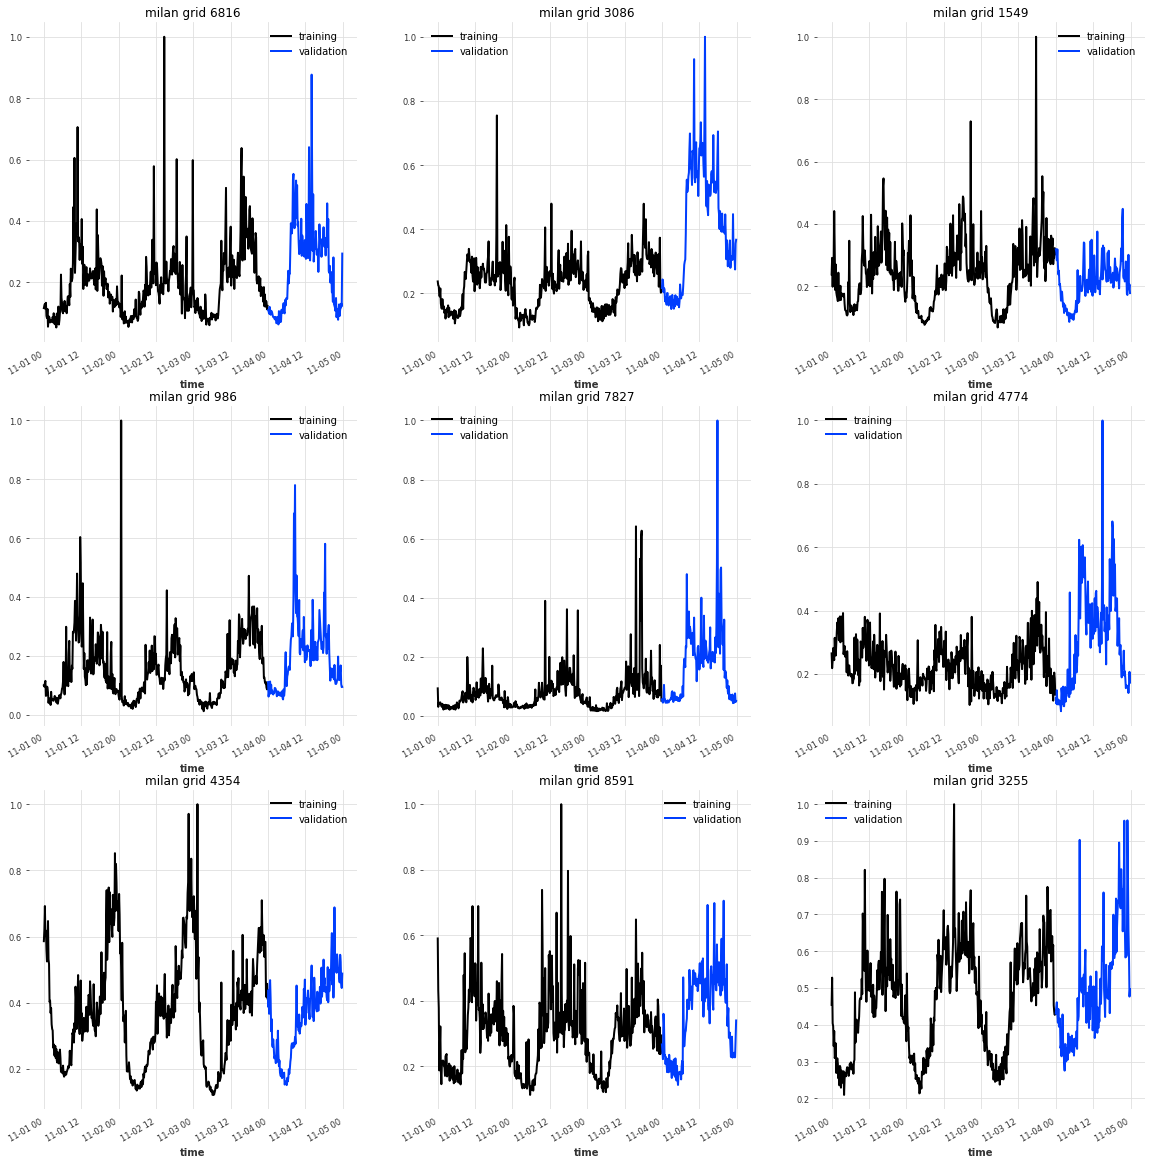

In [21]:
fig = plt.figure(figsize=(20, 20))
for i, c in enumerate(np.random.randint(10000, size=9)):
    ax = fig.add_subplot(3, 3, i + 1)
    train.univariate_component(int(c)).plot(label="training")
    val.univariate_component(int(c)).plot(label="validation")
    ax.title.set_text(f"milan grid {c}")

In [22]:
from darts.models import ARIMA, NaiveDrift, NaiveSeasonal, NBEATSModel, FourTheta, ExponentialSmoothing
from darts.metrics import mase, rmse

/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
[2022-03-18 14:09:49,793] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:09:49,793] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:09:50,210] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:09:50,210] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU availabl

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
[2022-03-18 14:12:10,866] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:12:10,866] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:12:11,326] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:12:11,326] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU availabl

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
[2022-03-18 14:14:29,262] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:14:29,262] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:14:29,78

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

/home/zzw/miniconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
[2022-03-18 14:16:50,561] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:16:50,561] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:16:50,988] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:16:50,988] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

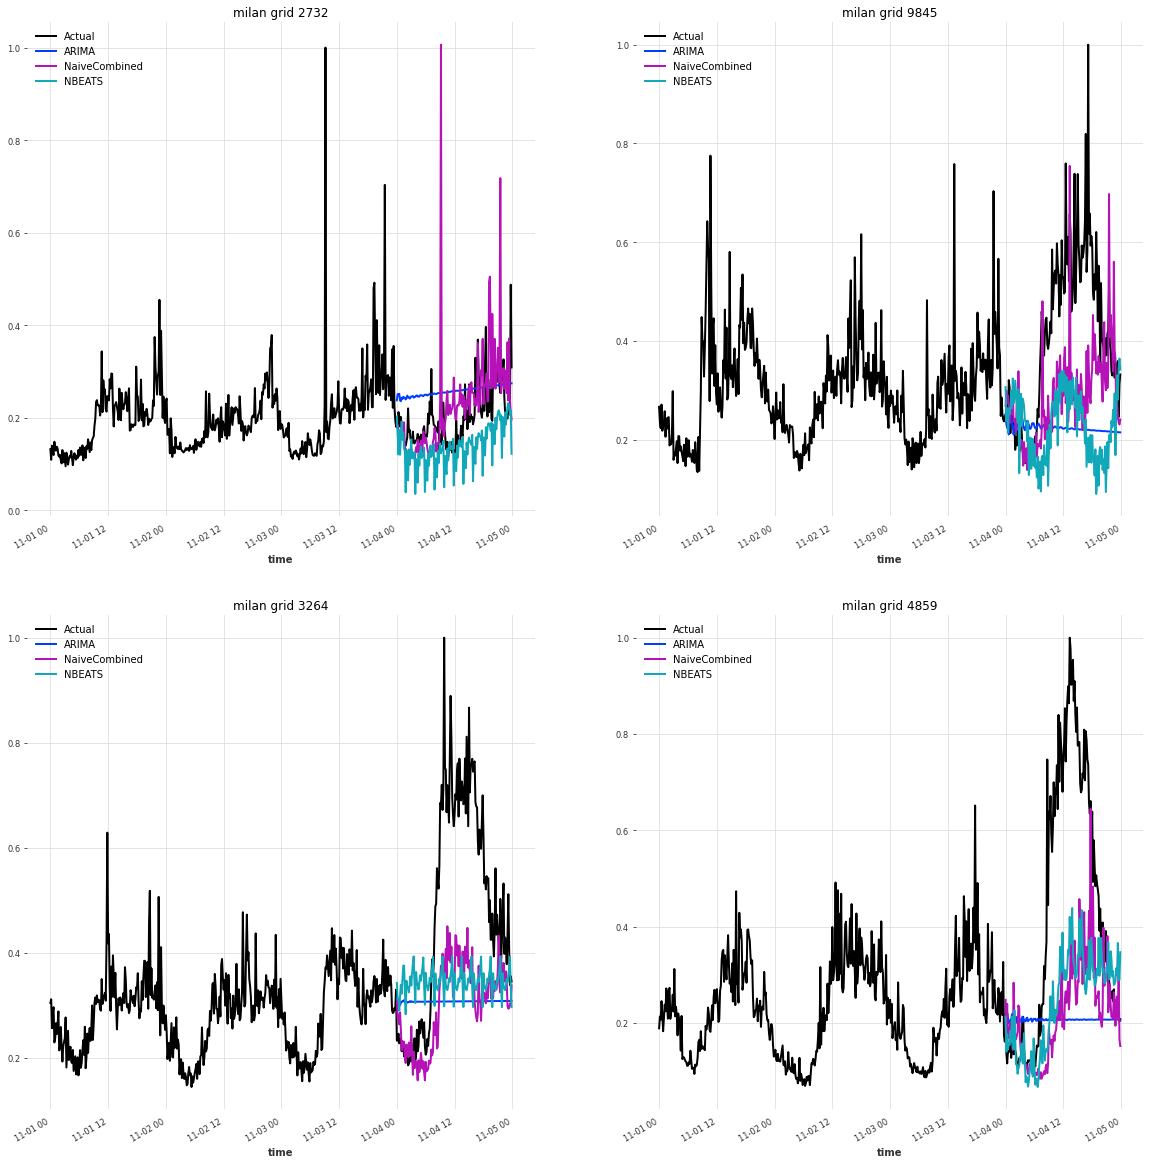

In [27]:
fig = plt.figure(figsize=(20, 20))
for i, c in enumerate(np.random.randint(10000, size=4)):
    c = int(c)
    ax = fig.add_subplot(2, 2, i + 1)
    internet_series.univariate_component(c).plot(label="Actual")

    arima_model = ARIMA(d=2, q=12)
    arima_model.fit(train.univariate_component(c))
    arima_forecast = arima_model.predict(predict_len)
    arima_forecast.plot(label="ARIMA")

    seasonal_model = NaiveSeasonal(K=144)
    seasonal_model.fit(train.univariate_component(c))
    seasonal_forecast = seasonal_model.predict(predict_len)

    drift_model = NaiveDrift()
    drift_model.fit(train.univariate_component(c))
    drift_forecast = drift_model.predict(predict_len)

    combined_forecast = seasonal_forecast + drift_forecast - train.univariate_component(c).last_value()
    combined_forecast.plot(label="NaiveCombined")

    nbeats_model = NBEATSModel(
        input_chunk_length=24, 
        output_chunk_length=12,
        random_state=42,
        generic_architecture=True,
        num_blocks=3,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        pl_trainer_kwargs={"accelerator": "gpu", "gpus": [0]},
    )
    nbeats_model.fit(train.univariate_component(c), epochs=50)
    nbeats_forecast = nbeats_model.predict(predict_len, series=train.univariate_component(c))
    nbeats_forecast.plot(label="NBEATS")

    ax.title.set_text(f"milan grid {c}")

[2022-03-18 14:37:14,296] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:37:14,296] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:37:14,689] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:37:14,689] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

[2022-03-18 14:39:31,242] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:39:31,242] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:39:31,925] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:39:31,925] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

[2022-03-18 14:41:48,802] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:41:48,802] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:41:49,285] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:41:49,285] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

[2022-03-18 14:44:05,711] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:44:05,711] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:44:06,124] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:44:06,124] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

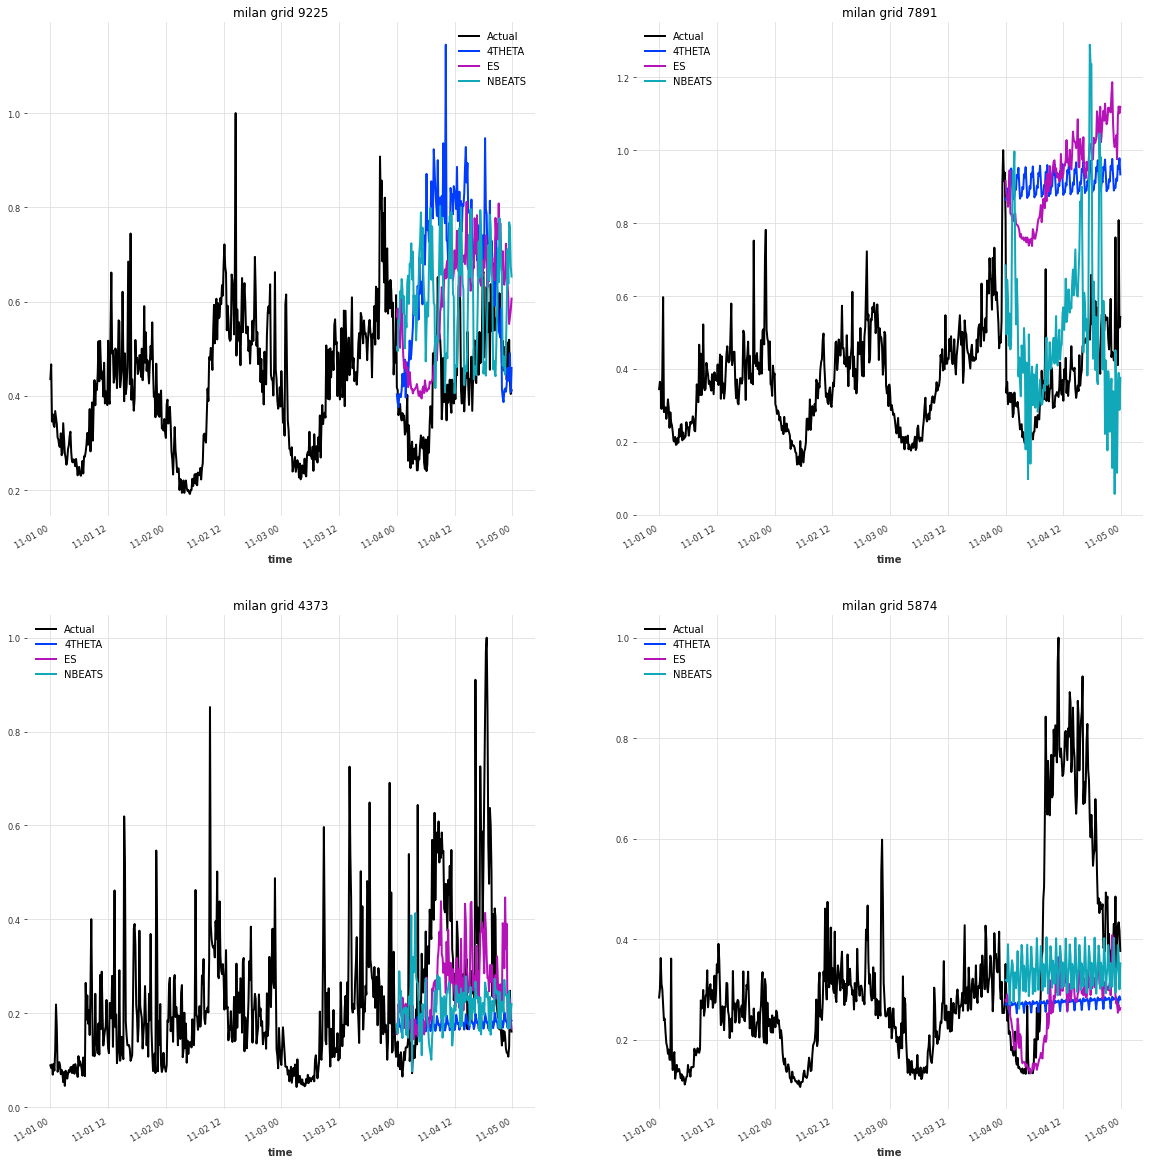

In [29]:
fig = plt.figure(figsize=(20, 20))
for i, c in enumerate(np.random.randint(10000, size=4)):
    c = int(c)
    ax = fig.add_subplot(2, 2, i + 1)
    internet_series.univariate_component(c).plot(label="Actual")

    theta_model = FourTheta()
    theta_model.fit(train.univariate_component(c))
    theta_forecast = theta_model.predict(predict_len)
    theta_forecast.plot(label="4THETA")

    es_model = ExponentialSmoothing(seasonal_periods=144)
    es_model.fit(train.univariate_component(c))
    es_forecast = es_model.predict(predict_len)
    es_forecast.plot(label="ES")

    nbeats_model = NBEATSModel(
        input_chunk_length=24, 
        output_chunk_length=12,
        random_state=42,
        generic_architecture=True,
        num_blocks=3,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        pl_trainer_kwargs={"accelerator": "gpu", "gpus": [0]},
    )
    nbeats_model.fit(train.univariate_component(c), epochs=50)
    nbeats_forecast = nbeats_model.predict(predict_len)
    nbeats_forecast.plot(label="NBEATS")

    ax.title.set_text(f"milan grid {c}")

[2022-03-18 14:19:12,399] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1588 samples.
[2022-03-18 14:19:12,399] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1588 samples.
[2022-03-18 14:19:12,798] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:19:12,798] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2022-03-18 14:27:50,654] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:27:50,654] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:27:51,066] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:27:51,066] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 50it [00:00, ?it/s]

[2022-03-18 14:30:11,189] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:30:11,189] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:30:11,585] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:30:11,585] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 50it [00:00, ?it/s]

[2022-03-18 14:32:32,694] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:32:32,694] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:32:33,371] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:32:33,371] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 50it [00:00, ?it/s]

[2022-03-18 14:34:53,481] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:34:53,481] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 397 samples.
[2022-03-18 14:34:53,866] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-18 14:34:53,866] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 72.6 M
-----------------------------------------
72.5 M    Trainable params
2.7 K     Non-trainable params
72.6 M    Total params
580.402   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 13it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: 50it [00:00, ?it/s]

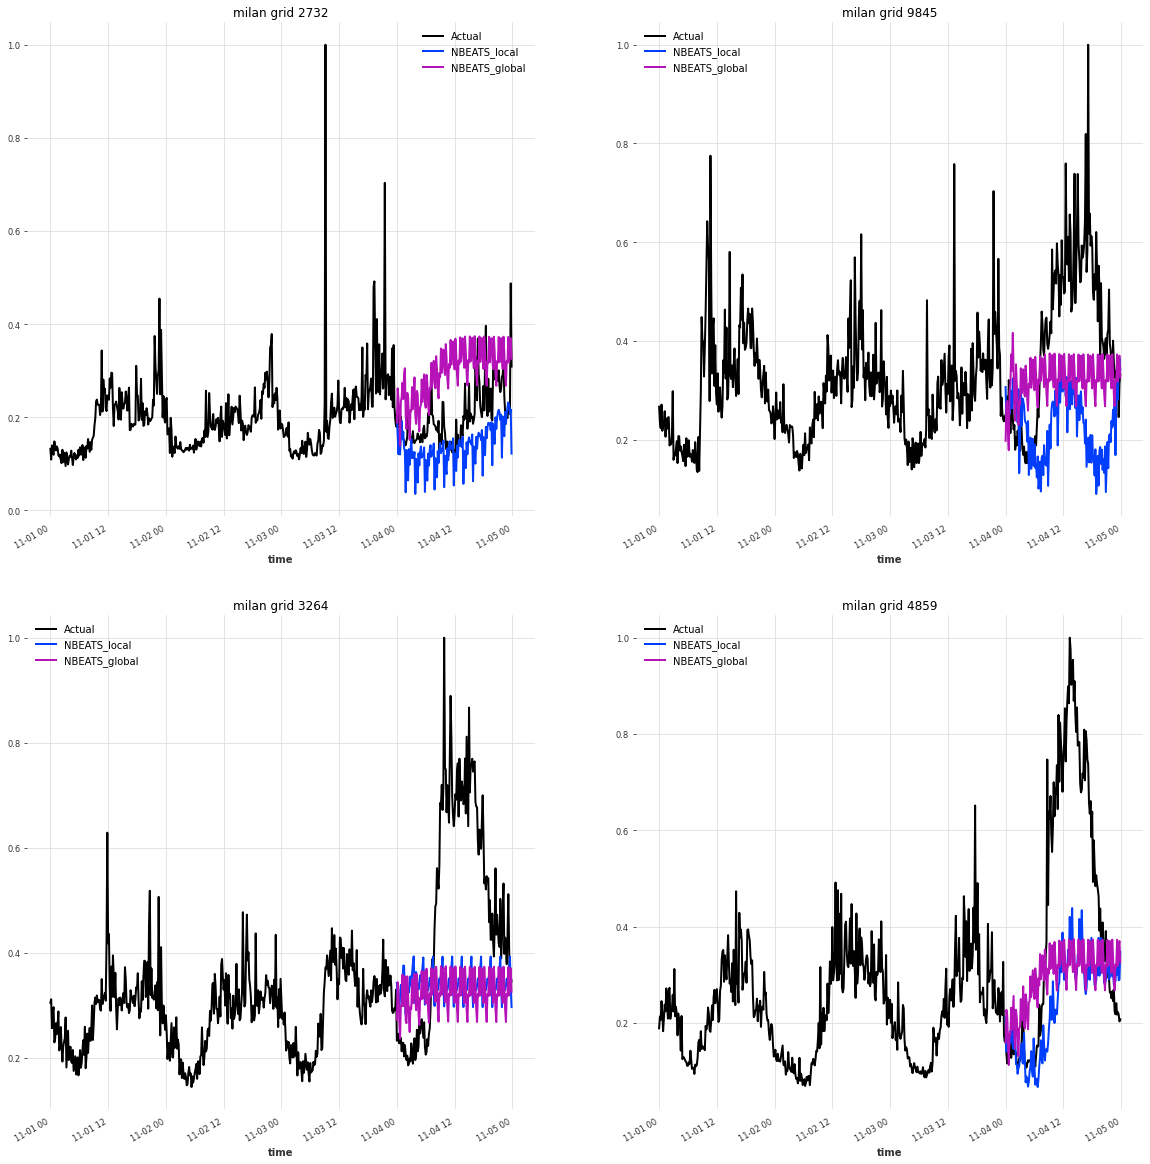

In [28]:
fig = plt.figure(figsize=(20, 20))
grids = np.random.randint(10000, size=4)
nbeats_global_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12,
    random_state=42,
    generic_architecture=True,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu", "gpus": [0]},
)
nbeats_global_model.fit([train.univariate_component(int(c)) for c in grids], epochs=50)

for i, c in enumerate(grids):
    c = int(c)
    ax = fig.add_subplot(2, 2, i + 1)
    internet_series.univariate_component(c).plot(label="Actual")

    nbeats_model = NBEATSModel(
        input_chunk_length=24, 
        output_chunk_length=12,
        random_state=42,
        generic_architecture=True,
        num_blocks=3,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        pl_trainer_kwargs={"accelerator": "gpu", "gpus": [0]},
    )
    nbeats_model.fit(train.univariate_component(c), epochs=50)
    nbeats_forecast = nbeats_model.predict(predict_len, series=train.univariate_component(c))
    nbeats_forecast.plot(label="NBEATS_local")

    nbeats_global_forecast = nbeats_global_model.predict(predict_len, series=train.univariate_component(c))
    nbeats_global_forecast.plot(label="NBEATS_global")

    ax.title.set_text(f"milan grid {c}")

In [14]:
import warnings
warnings.filterwarnings("ignore")

rng = default_rng()
grids = rng.choice(10000, size=1000, replace=False)

In [ ]:
mases = []
rmses = []
for c in tqdm(grids):
    c = int(c)
    series = internet_series.univariate_component(c)
    train_s = train.univariate_component(c)
    arima_model = ARIMA()
    arima_model.fit(train_s)
    arima_forecast = arima_model.predict(predict_len)
    m_mase = mase(series, arima_forecast, train_s)
    m_rmse = rmse(series, arima_forecast)
    mases.append(m_mase)
    rmses.append(m_rmse)

print("ARIMA MAPE:", np.mean(mases), "+-", np.std(mases), "RMSE:", np.mean(rmses), "+-", np.std(rmses))

In [75]:
naive_mases = []
naive_rmses = []
for c in tqdm(grids):
    c = int(c)
    series = internet_series.univariate_component(c)
    seasonal_model = NaiveSeasonal(K=12)
    seasonal_model.fit(train.univariate_component(c))
    seasonal_forecast = seasonal_model.predict(predict_len)

    drift_model = NaiveDrift()
    drift_model.fit(train.univariate_component(c))
    drift_forecast = drift_model.predict(predict_len)

    combined_forecast = seasonal_forecast + drift_forecast - train.univariate_component(c).last_value()
    m_mase = mase(series, combined_forecast, train.univariate_component(c))
    m_rmse = rmse(series, combined_forecast)
    naive_mases.append(m_mase)
    naive_rmses.append(m_rmse)

print("NAIVE MAPE:", np.mean(naive_mases), "+-", np.std(naive_mases), "RMSE:", np.mean(naive_rmses), "+-", np.std(naive_rmses))

100%|██████████| 1000/1000 [00:20<00:00, 48.25it/s]

NAIVE MAPE: 2.8227490592106 +- 2.2056824768257166 RMSE: 0.24831196141976886 +- 0.11645839715394439


In [19]:
import logging
logging.basicConfig(level=logging.ERROR)

nbeats_mases = []
nbeats_rmses = []
for c in tqdm(grids):
    c = int(c)
    series = internet_series.univariate_component(i)
    nbeats_model = NBEATSModel(
        input_chunk_length=24, 
        output_chunk_length=12,
        random_state=42,
        generic_architecture=False,
        num_blocks=3,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        log_tensorboard=True,
        show_warnings=False,
        pl_trainer_kwargs={
            "accelerator": "gpu", 
            "gpus": [0],
            "enable_model_summary": False,
            "enable_progress_bar": False,
            "progress_bar_refresh_rate": 0,
            "logger": None,
        }
    )
    nbeats_model.fit(train.univariate_component(c), epochs=100, verbose=False)
    nbeats_forecast = nbeats_model.predict(predict_len, verbose=False)
    m_mase = mase(series, nbeats_forecast, train.univariate_component(c))
    m_rmse = rmse(series, nbeats_forecast)
    nbeats_mases.append(m_mase)
    nbeats_rmses.append(m_rmse)

print("NBEATS MAPE:", np.mean(nbeats_mases), "+-", np.std(nbeats_mases), "RMSE:", np.mean(nbeats_rmses), "+-", np.std(nbeats_rmses))

  0%|          | 0/1000 [00:00<?, ?it/s][2022-03-14 21:43:43,400] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-03-14 21:43:43,400] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 73 samples.
[2022-03-14 21:43:43,417] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-14 21:43:43,417] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.
[2022-03-14 21:43:43,419] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Tra